## Training a simple NN to identify particles in PID

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
import hist
import pyphysics as phys
import awkward as ak
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Concatenate

2025-05-29 17:01:36.579375: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 17:01:36.580302: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 17:01:36.582642: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-29 17:01:36.589696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748530896.603001   17266 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748530896.60

### Preparing the data

In [3]:
labels = ["p", "d", "t"]
data = ak.Array([])
for i, batch in enumerate(uproot.iterate(["./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree", 
                                          "./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree", 
                                          "./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree"])):
    batch["label"] = labels[i]#type: ignore
    # batch.type.show() #type: ignore
    data = ak.concatenate([data, batch])

# And gate on events reaching the second layer of silicons
data : ak.Array
data = data[data["dE1"] > 0]
data

<Array [{dEgas: 0.218, dE0: 11.5, ...}, ...] type='188112 * {dEgas: float64...'>

<BarContainer object of 3 artists>

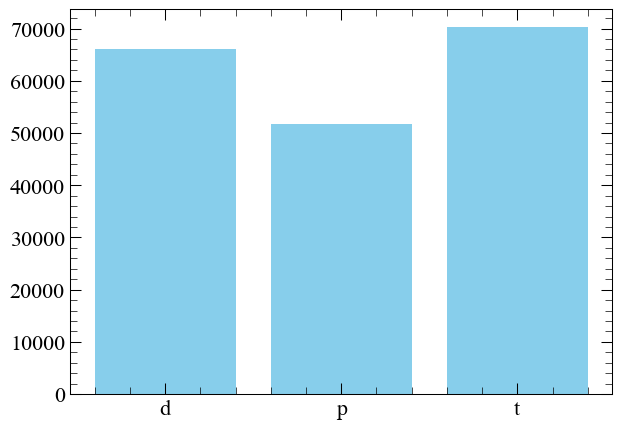

In [4]:
labels, counts = np.unique(data["label"], return_counts=True)
labels = ak.ravel(labels)
counts = ak.ravel(counts)
plt.bar(labels, counts, color="skyblue")

<BarContainer object of 3 artists>

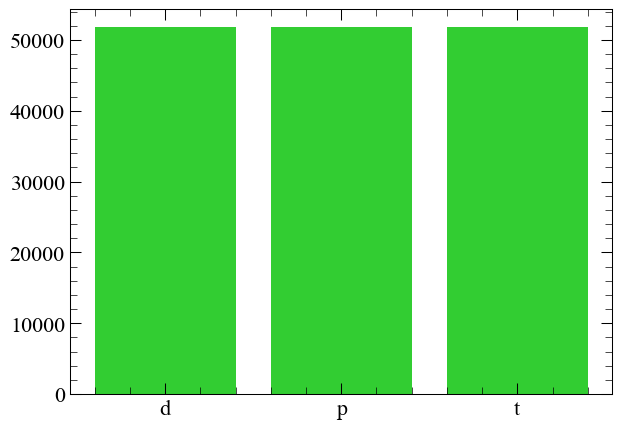

In [5]:
# Downsample so we have same counts for all clasess
minority_counts = counts[np.argmin(counts)]
minority_label = labels[np.argmin(counts)]

data_downsampled = data[data.label == minority_label]
for label in labels:
    if label == minority_label:
        continue
    mask = (data.label == label)
    idxs = ak.where(mask)[0]
    sampled = np.random.choice(idxs, minority_counts, replace=False) # do not allow sample with replacement
    data_downsampled = ak.concatenate([data_downsampled, data[sampled]])

# And randomly shuffle entries so they are uniformly distributed
permutations = np.random.permutation(len(data_downsampled))
data_downsampled = data_downsampled[permutations]

# Use shorter name
dfs = data_downsampled

ok_labels, ok_counts = np.unique(dfs.label, return_counts=True)
ok_labels = ak.ravel(ok_labels)
ok_counts = ak.ravel(ok_counts)
plt.bar(ok_labels, ok_counts, color="limegreen")

Plotting the data we will train

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x758c0504a620>, cbar=<matplotlib.colorbar.Colorbar object at 0x758c046aa4a0>, text=[])

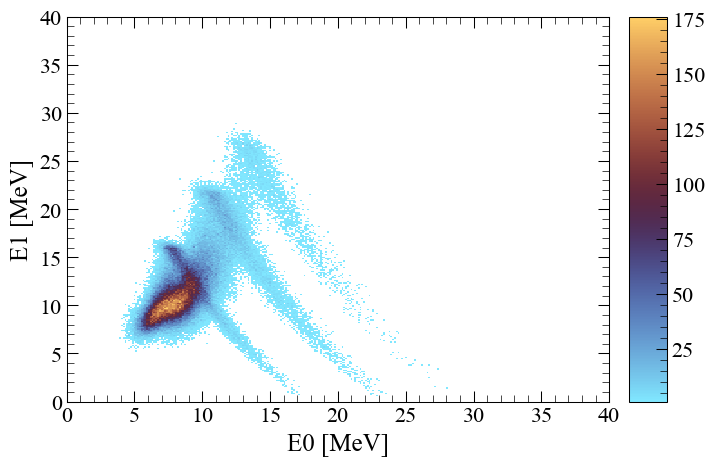

In [6]:
hdE01 = hist.Hist.new.Regular(300, 0, 40, label="E0 [MeV]").Regular(300, 0, 40, label="E1 [MeV]").Double()
hdE01.fill(dfs["dE0"], dfs["dE1"])

hdE01.plot(cmin=1, cmap="managua_r")

In [16]:
# Split columns into "plain,float" type and "profile, vector" type
drop_plain = ["profx", "profy"]
keep_prof = ["profx", "profy", "label"]
plain_data = ak.zip({col: dfs[col] for col in dfs.fields if col not in drop_plain})
prof_data = ak.zip({col: dfs[col] for col in dfs.fields if col in keep_prof})

# And convert plain data to pandas
plain_df = ak.to_dataframe(plain_data)

And its covariance matrix


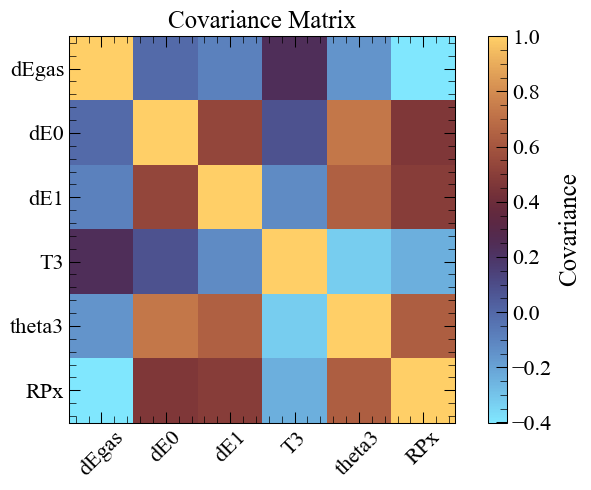

In [19]:
cov_matrix = plain_df.drop(columns=["label", "T3After1"], axis=1).corr()

plt.imshow(cov_matrix, cmap='managua_r', interpolation='none')
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=45)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix')
plt.tight_layout()

In [ ]:
## Convert to numpy
X = plain_df.drop(columns=["label", "T3", "T3After1"]).values
X_prof = ak.to_numpy(prof_data["profy"])
X_prof = X_prof[..., np.newaxis] ## Keras expects (Nevents, Nsamples, Nfeatures = 1)
## so we have to force the adding of an auxiliary axis to have the correct shape
y = plain_df["label"].values

# Encode str labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform((X))

### Defining the model

In [21]:
model = Sequential([
    Input(shape=(X_scaled.shape[1],)), 
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(len(encoder.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

2025-05-29 17:08:11.331575: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,723 (26.26 KB)

 Trainable params: 6,723 (26.26 KB)

 Non-trainable params: 0 (0.00 B)

### Train and eval

In [22]:
early = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
history = model.fit(X_scaled, y_encoded, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early])

Epoch 1/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7246 - loss: 0.6179 - val_accuracy: 0.7885 - val_loss: 0.4854
Epoch 2/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - accuracy: 0.7900 - loss: 0.4807 - val_accuracy: 0.7935 - val_loss: 0.4700
Epoch 3/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step - accuracy: 0.7948 - loss: 0.4669 - val_accuracy: 0.7955 - val_loss: 0.4632
Epoch 4/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - accuracy: 0.7984 - loss: 0.4596 - val_accuracy: 0.7862 - val_loss: 0.4789
Epoch 5/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7982 - loss: 0.4594 - val_accuracy: 0.7946 - val_loss: 0.4644
Epoch 6/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - accuracy: 0.7974 - loss: 0.4606 - val_accuracy: 0.7960 - val_loss: 0.4613
Epoch 7/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7996 - loss: 0.4570 - val_accuracy: 0.7986 - val_loss: 0.4596
Epoch 8/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8004 - loss: 0

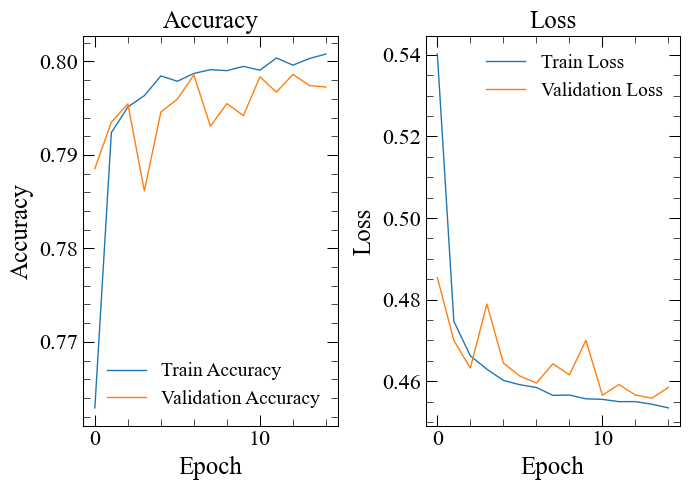

In [31]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

4854/4854 ━━━━━━━━━━━━━━━━━━━━ 2s 492us/step


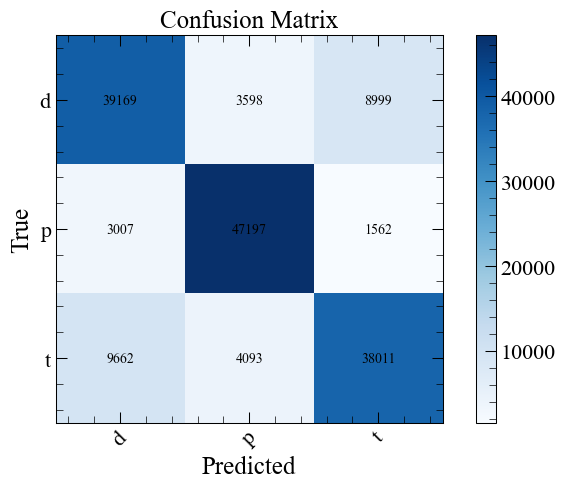

In [32]:
# Confusion matrix
y_pred = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_encoded, y_pred_classes)

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add color bar
plt.colorbar()

# Annotate matrix with counts
classes = encoder.classes_
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set ticks
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

plt.tight_layout()

Which region is poorly reconstructed?

In [33]:
misclassified = (y_pred_classes != y_encoded)

df_mis = plain_df[misclassified].copy()
df_mis["label_rec"] = encoder.inverse_transform(y_pred_classes[misclassified])
df_mis.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,label,label_rec
entry,,,,,,,,,
1,0.202352,8.336010,9.694439,38.088028,12.682424,198.254907,19.757817,d,t
11,0.409869,8.891605,10.851559,56.979236,12.067495,20.754168,36.811989,t,d
17,0.158864,8.265326,12.268840,24.923889,17.981156,212.419963,4.206225,p,d
19,0.074063,7.938499,9.478400,38.122849,12.423165,232.216948,20.556253,d,t
23,0.303317,8.162226,8.910414,39.051349,14.609541,97.969454,21.748627,d,t


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x758bef44ef80>, cbar=None, text=[])

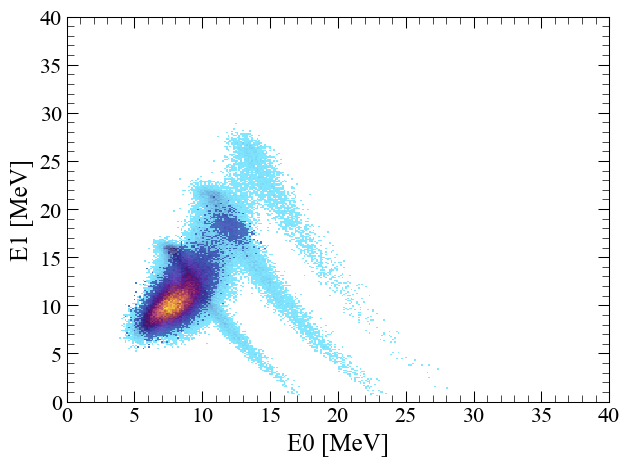

In [34]:
hdE01Mis = hdE01.copy()
hdE01Mis.reset()
hdE01Mis.fill(df_mis["dE0"], df_mis["dE1"])

hdE01.plot(cmin = 1, cmap="managua_r", cbar=None)
hdE01Mis.plot(cmin = 1, cmap="plasma", alpha=0.5, cbar=None)

So it seems it is really complicated to separate particles with this method: the NN won't do anything we cannot separate by hand: $\theta$ is a free parameter that allows the event to be either (d,p), (d,d) or (d,t) by changing Ex.

## Kinematical separation

In [ ]:

for r in ["(d,p)", "(d,d)", "(d,t)"]:
    kin = phys.KinInterface(f"11Li{r}@81.5")
    kin.plot_kin3(lw=2, label=r)
phys.KinInterface("11Li(d,t)@81.5|5").plot_kin3(lw=2, label="(d,t) Ex = 5 MeV")
plt.legend(fontsize=14)

 *** Break *** segmentation violation



There was a crash.
This is the entire stack trace of all threads:

Thread 65 (Thread 0x758aaf7fe640 (LWP 21700) "python3"):
#0  __futex_abstimed_wait_common64 (private=<optimized out>, cancel=true, abstime=0x0, op=393, expected=0, futex_word=0x758acc005b60) at ./nptl/futex-internal.c:57
#1  __futex_abstimed_wait_common (cancel=true, private=<optimized out>, abstime=0x0, clockid=0, expected=0, futex_word=0x758acc005b60) at ./nptl/futex-internal.c:87
#2  __GI___futex_abstimed_wait_cancelable64 (futex_word=futex_word
entry=0x758acc005b60, expected=expected
entry=0, clockid=clockid
entry=0, abstime=abstime
entry=0x0, private=<optimized out>) at ./nptl/futex-internal.c:139
#3  0x0000758cabe9cbdf in do_futex_wait (sem=sem
entry=0x758acc005b60, abstime=0x0, clockid=0) at ./nptl/sem_waitcommon.c:111
#4  0x0000758cabe9cc78 in __new_sem_wait_slow64 (sem=0x758acc005b60, abstime=0x0, clockid=0) at ./nptl/sem_waitcommon.c:183
#5  0x00005cef05578f20 in PyThre

So reconstruction event-by-event the Elab assuming either p, d or t and checking which events fall within the kinematical boundaries would be fine.

## Conv1D

Attempt to improve reconstruction with a Conv1D layer.

In [35]:
# Plain input
plain_input = Input(shape=(X_scaled.shape[1],), name="plain_input")
x_plain = Dense(64, activation="relu")(plain_input)
x_plain = Dense(64, activation="relu")(x_plain)
x_plain = Dense(32, activation="relu")(x_plain)

# Time series input branch (example: 100 timesteps, 1 channel)
prof_input = Input(shape=(X_prof.shape[1], X_prof.shape[2]), name="prof_input")
x_prof = Conv1D(32, kernel_size=3, activation="relu", padding="same")(prof_input)
x_prof = Conv1D(32, kernel_size=3, activation="relu", padding="same")(x_prof)
x_prof = Flatten()(x_prof)
x_prof = Dense(32, activation="relu")(x_prof)

# Combine both branches
combined = Concatenate()([x_plain, x_prof])
x = Dense(32, activation="relu")(combined)
output = Dense(len(encoder.classes_), activation="softmax")(x)

model = Model(inputs=[plain_input, prof_input], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ prof_input          │ (None, 145, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plain_input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 145, 32)   │        128 │ prof_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │        384 │ plain_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 145, 32)   │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4640)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │    148,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │         99 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,547 (627.14 KB)

 Trainable params: 160,547 (627.14 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    [X_scaled, X_prof],  # List of inputs
    y_encoded,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early]
)

Epoch 1/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7296 - loss: 0.6041 - val_accuracy: 0.7837 - val_loss: 0.4901
Epoch 2/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7916 - loss: 0.4751 - val_accuracy: 0.7904 - val_loss: 0.4741
Epoch 3/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7918 - loss: 0.4719 - val_accuracy: 0.7968 - val_loss: 0.4587
Epoch 4/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8068 - loss: 0.4465 - val_accuracy: 0.8469 - val_loss: 0.3552
Epoch 5/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8652 - loss: 0.3174 - val_accuracy: 0.8827 - val_loss: 0.2788
Epoch 6/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8947 - loss: 0.2549 - val_accuracy: 0.9045 - val_loss: 0.2294
Epoch 7/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9074 - loss: 0.2262 - val_accuracy: 0.9134 - val_loss: 0.2232
Epoch 8/15
1942/1942 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9148 - loss: 0.2157 - 

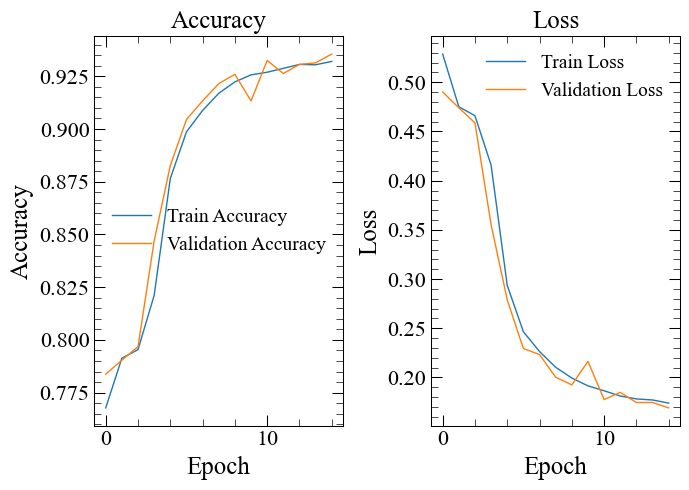

In [37]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

4854/4854 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x758b5de04100>, cbar=None, text=[])

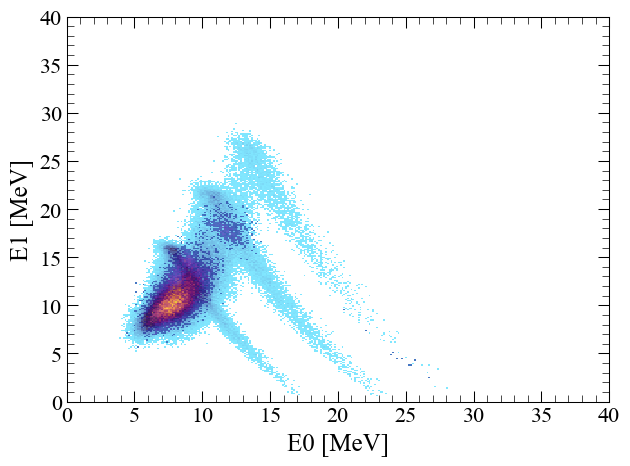

In [39]:

# Confusion matrix
y_pred = model.predict([X_scaled, X_prof])
y_pred_classes = np.argmax(y_pred, axis=1)

misclassified = (y_pred_classes != y_encoded)

df_mis = plain_df[misclassified].copy()
df_mis["label_rec"] = encoder.inverse_transform(y_pred_classes[misclassified])
df_mis.head()
hdE01Mis = hdE01.copy()
hdE01Mis.reset()
hdE01Mis.fill(df_mis["dE0"], df_mis["dE1"])

hdE01.plot(cmin = 1, cmap="managua_r", cbar=None)
hdE01Mis.plot(cmin = 1, cmap="plasma", alpha=0.5, cbar=None)